In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import os
import tqdm
import random
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


## Create Dataframe for Input and Output

In [41]:
data_path = []
label = []

imgs_path = Path.cwd().parent / "data" 

print(f"Images path: {imgs_path}")

for pet in os.listdir(imgs_path):
    for img in tqdm.tqdm(os.listdir(imgs_path / pet)):
        if pet == "Cat":
            data_path.append(str(imgs_path / pet / img))
            label.append(0)
        else:
            data_path.append(str(imgs_path / pet / img))
            label.append(1)
print(f"Total number of images: {len(data_path)}")
print(f"Total number of images: {len(label)}")


Images path: /home/kavin/career/me/github/kkr-gen-ai-internship/cats-and-dogs-classification/data


  0%|          | 0/12499 [00:00<?, ?it/s]

100%|██████████| 12499/12499 [00:00<00:00, 86471.58it/s]

Total number of images: 24998
Total number of images: 24998


In [42]:
for i in range(5):
    print(f"{i+1}. {data_path[i]}: {label[i]}")

1. /home/kavin/career/me/github/kkr-gen-ai-internship/cats-and-dogs-classification/data/Dog/6854.jpg: 1
2. /home/kavin/career/me/github/kkr-gen-ai-internship/cats-and-dogs-classification/data/Dog/4352.jpg: 1
3. /home/kavin/career/me/github/kkr-gen-ai-internship/cats-and-dogs-classification/data/Dog/10451.jpg: 1
4. /home/kavin/career/me/github/kkr-gen-ai-internship/cats-and-dogs-classification/data/Dog/474.jpg: 1
5. /home/kavin/career/me/github/kkr-gen-ai-internship/cats-and-dogs-classification/data/Dog/8417.jpg: 1


In [43]:
df = pd.DataFrame()
df["data_path"] = data_path
df["label"] = label

In [44]:
df['label'] = df['label'].astype('str')
df.head()

,data_path,label
0,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
1,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
2,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
3,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
4,/home/kavin/career/me/github/kkr-gen-ai-intern...,1


In [45]:
df = df.sample(frac=1).reset_index(drop=True)# Shuffle the DataFrame
df.head()


,data_path,label
0,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
1,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
2,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
3,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
4,/home/kavin/career/me/github/kkr-gen-ai-intern...,0


In [62]:
for i in df['data_path']:
    if ".jpg" not in i:
        print(i)

## Exploratory Data Analysis

In [46]:
plt.figure(figsize=(25,25))
dog_imgs = df[df["label"] == 1]["data_path"]
start = random.randint(0, len(dog_imgs))
files = dog_imgs[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title("dogs")
    plt.axis("off")

<Figure size 2500x2500 with 0 Axes>

In [47]:
plt.figure(figsize=(25,25))
cat_imgs = df[df["label"] == 0]["data_path"]
start = random.randint(0, len(cat_imgs))
files = cat_imgs[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title("dogs")
    plt.axis("off")

<Figure size 2500x2500 with 0 Axes>

<Axes: xlabel='label', ylabel='count'>

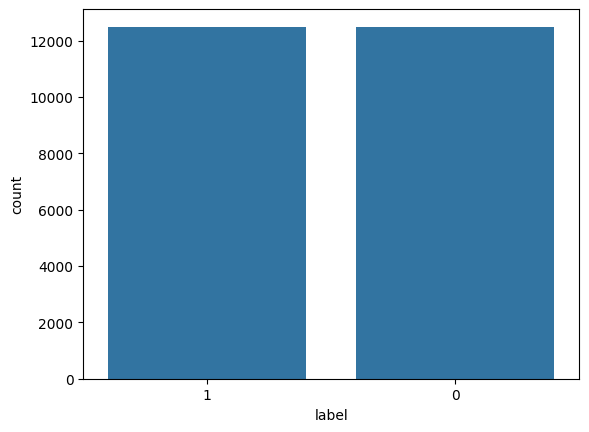

In [48]:
sns.countplot(x="label", data=df)

In [57]:
# Data splitting
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [58]:
train.head()

,data_path,label
23286,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
17781,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
1020,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
12644,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
1533,/home/kavin/career/me/github/kkr-gen-ai-intern...,1


In [59]:
test.head()

,data_path,label
6868,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
22910,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
9668,/home/kavin/career/me/github/kkr-gen-ai-intern...,0
13638,/home/kavin/career/me/github/kkr-gen-ai-intern...,1
23337,/home/kavin/career/me/github/kkr-gen-ai-intern...,1


## Create Data Generator for the Images

In [60]:

train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=40,          # Augment images by rotating them to avoid overfitting
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_iterator = train_datagenerator.flow_from_dataframe(
    dataframe=train,
    directory=None,             # Since data_path contains full paths, we set directory to None
    x_col='data_path',
    y_col='label',
    target_size=(128, 128),     # Resize images to 150x150 pixels
    batch_size=512,
    class_mode='binary'         # Binary classification (cats vs dogs)
)   

val_iterator = val_generator.flow_from_dataframe(
    dataframe=test,
    directory=None,             # Since data_path contains full paths, we set directory to None
    x_col='data_path',
    y_col='label',
    target_size=(128, 128),     # Resize images to 150x150 pixels
    batch_size=512,
    class_mode='binary'         # Binary classification (cats vs dogs)
)   

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [51]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

E0000 00:00:1752305079.765568   11697 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752305079.766826   11697 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [65]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_iterator,
    steps_per_epoch=len(train_iterator),
    epochs=50,
    validation_data=val_iterator,  # You can add validation data if available
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.5034 - loss: 0.8026
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5924 - loss: 0.6710
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6341 - loss: 0.6419
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6586 - loss: 0.6164
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6786 - loss: 0.5963
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6895 - loss: 0.5860
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6992 - loss: 0.5716
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7212 - loss: 0.5485
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7263 - loss: 0.5348
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.7193 - loss: 0.5463
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.7400 - loss: 0.5253
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.726

## Save the model

In [66]:
model.save('model_50.keras')

## Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(range(epochs), acc, 'b', label='Training Accuracy')
# plt.plot(range(epochs), val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(range(epochs), acc, 'b', label='Training Loss')
# plt.plot(range(epochs), val_acc, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()